In [1]:
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import unicodedata
import re
import os
import io
from bpemb import BPEmb

In [2]:
bpemb_1 = BPEmb(lang='en', vs=10000, dim=100)
bpemb_2 = BPEmb(lang='de', vs=10000, dim=100)


In [3]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64
MAX_LENGTH = 40
vocab_size = 10000

In [4]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)


In [5]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)


In [6]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights


class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights


In [7]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])


class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, attn_weights_block1 = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2, attn_weights_block1


class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)


  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2


In [8]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)


    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}


    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block = self.enc_layers[i](x, training, mask)
    
      attention_weights['encoder_layer{}_block'.format(i+1)] = block

    return x, attention_weights  # (batch_size, input_seq_len, d_model)

class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights


In [9]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output, attention_weights_encoder = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights_decoder = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights_encoder, attention_weights_decoder


In [10]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = vocab_size + 2
target_vocab_size = vocab_size + 2
dropout_rate = 0.1


In [11]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)


In [12]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask


In [13]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)


In [14]:
checkpoint_path = "./checkpoints_deu/pretrained"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')


Latest checkpoint restored!!


In [15]:
def evaluate(inp_sentence):
  start_token = [vocab_size]
  end_token = [vocab_size + 1]

  # inp sentence is portuguese, hence adding the start and end token
  inp_sentence = start_token + bpemb_1.encode_ids(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)

  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [vocab_size]
  output = tf.expand_dims(decoder_input, 0)

  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights_encoder, attention_weights_decoder = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)

    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if predicted_id == vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights_encoder, attention_weights_decoder

    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights_encoder, attention_weights_decoder


In [16]:
import seaborn as sns
%matplotlib inline
mha_color_list = ['lightskyblue', 'orange', 'palegreen', 'orangered', 'blueviolet', 'burlywood', 'lightpink', 'darkgray']
encoder_self_attention_block_list = ['encoder_layer{}_block'.format(i) for i in (range(1, num_layers + 1) )] 
decoder_self_attention_block_list =  ['decoder_layer{}_block1'.format(i) for i in (range(1, num_layers + 1) )] 
decoder_inter_language_attention_block_list = ['decoder_layer{}_block2'.format(i) for i in (range(1, num_layers + 1) )]

def plot_attention_weights(attention, sentence_1, sentence_2, layer, bpemb_1, bpemb_2, img_name):
  fig = plt.figure(figsize=(16, 8))
  #my_suptitle = fig.suptitle('The heat maps of self attentions of "{input_sentence}" \n in {layer_name}'.format(input_sentence=, layer_name=layer), y=1.12, fontsize=30)

  sentence_1 = bpemb_1.encode_ids(sentence_1)
  sentence_2 = bpemb_2.encode_ids(sentence_2)

  attention = tf.squeeze(attention[layer], axis=0)
  
  #print(attention.shape)
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)

    # plot the attention weights
    #print(attention[head].shape)
    color_map = sns.light_palette(mha_color_list[head], as_cmap=True)
    ax = sns.heatmap(attention[head], cmap=color_map)
    
    #ax.matshow(attention[head], cmap='viridis')

    fontdict = {'fontsize': 10}

    ax.set_xticks(range(len(sentence_1)+2))
    ax.set_yticks(range(len(sentence_2)+2))

    #ax.set_ylim(len(sentence)-1.5, -0.5)

    ax.set_xticklabels(
        ['<start>']+[bpemb_1.decode_ids([i]) for i in sentence_1]+['<end>'], 
        fontdict=fontdict, rotation=90)

    ax.set_yticklabels(
        ['<start>']+[bpemb_2.decode_ids([i]) for i in sentence_2]+['<end>'], 
        fontdict=fontdict, rotation=0)
    #ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
    #                    if i < tokenizer_en.vocab_size], 
    #                   fontdict=fontdict)

    ax.set_xlabel('Head {}'.format(head+1), fontsize = 20)

  fig.tight_layout()
  if img_name is not None:
        #fig.savefig(img_name + '.png', bbox_inches='tight', bbox_extra_artists=[my_suptitle])
        fig.savefig(img_name + '.png')
  #fig.show()


In [17]:
def translate(sentence, plot=' ', img_name=None):
    result, attention_weights_encoder, attention_weights_decoder  = evaluate(sentence)

    result = result.numpy().tolist() 
    
    predicted_sentence = bpemb_2.decode_ids([i for i in result 
                                            if i < vocab_size])  
    
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))
    
    if plot in encoder_self_attention_block_list:
        plot_attention_weights(attention_weights_encoder,  sentence, sentence, plot, bpemb_1, bpemb_1, img_name)
    elif plot in decoder_self_attention_block_list:
        plot_attention_weights(attention_weights_decoder,  predicted_sentence, predicted_sentence, plot, bpemb_2, bpemb_2, img_name)
    elif plot in decoder_inter_language_attention_block_list:
        plot_attention_weights(attention_weights_decoder,  sentence, predicted_sentence, plot, bpemb_1, bpemb_2, img_name)
    elif plot!=' ':
        print("The model does not have such layer: " + str(plot) )
    


Input: He admired her as a great director.
Predicted translation: er bewunderte sie als großer direktor.


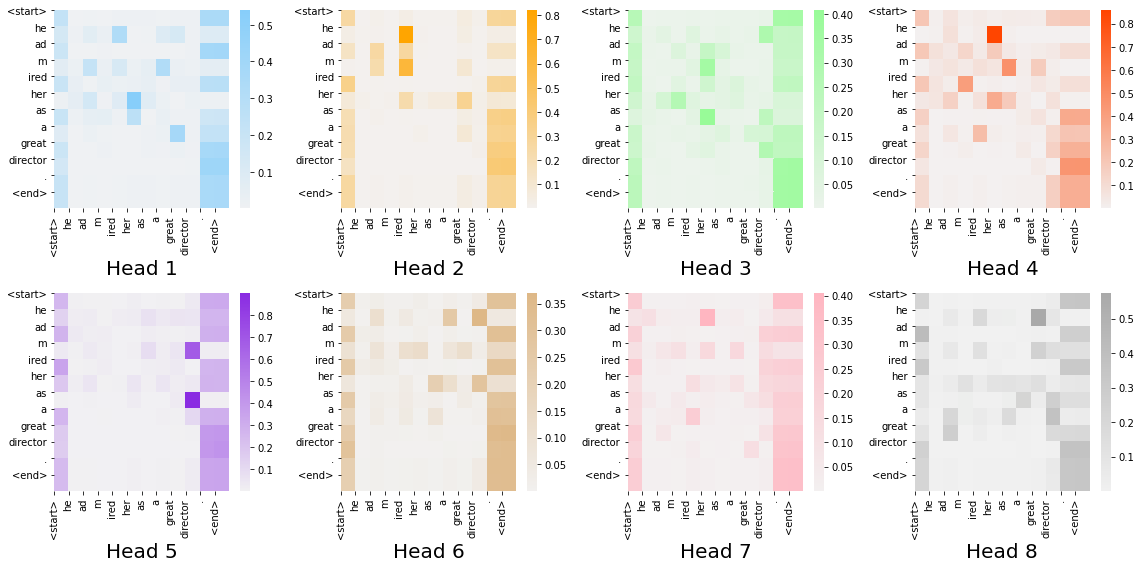

In [18]:
# As I mentioned in the fourth article, the last layer seems to focus on the beginnign and the end of sentences. 
translate("He admired her as a great director.", plot='encoder_layer4_block', img_name='sample_img_1')

Input: He admired her as a great director.
Predicted translation: er bewunderte sie als großer direktor.


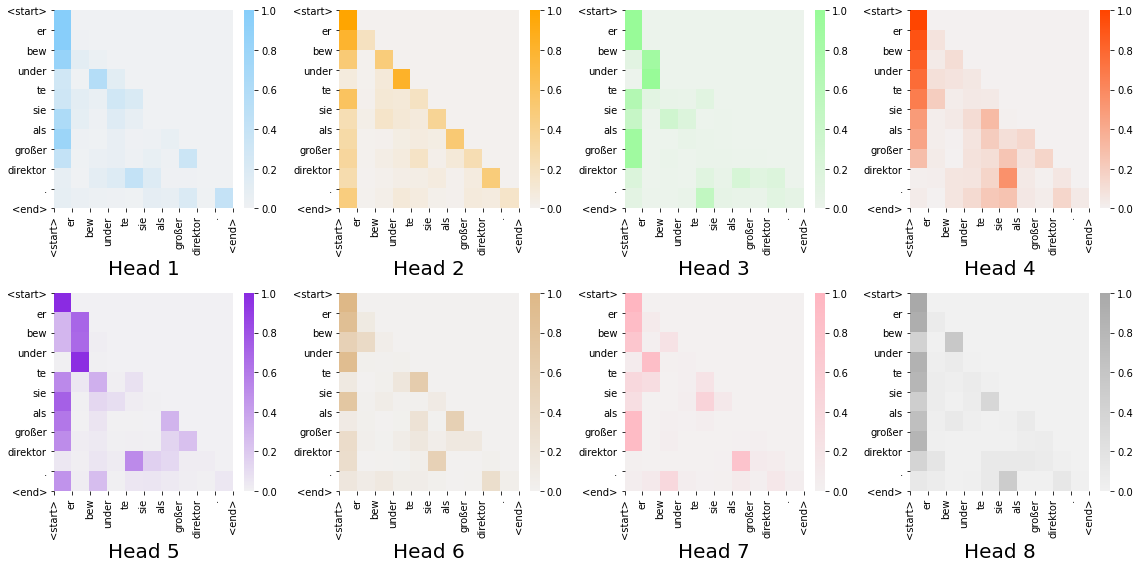

In [19]:
# The attention maps after applying look ahead mask is obviously lower triangular matrices.
translate("He admired her as a great director.", plot='decoder_layer4_block1', img_name='sample_img_2')

Input: He admired her as a great director.
Predicted translation: er bewunderte sie als großer direktor.


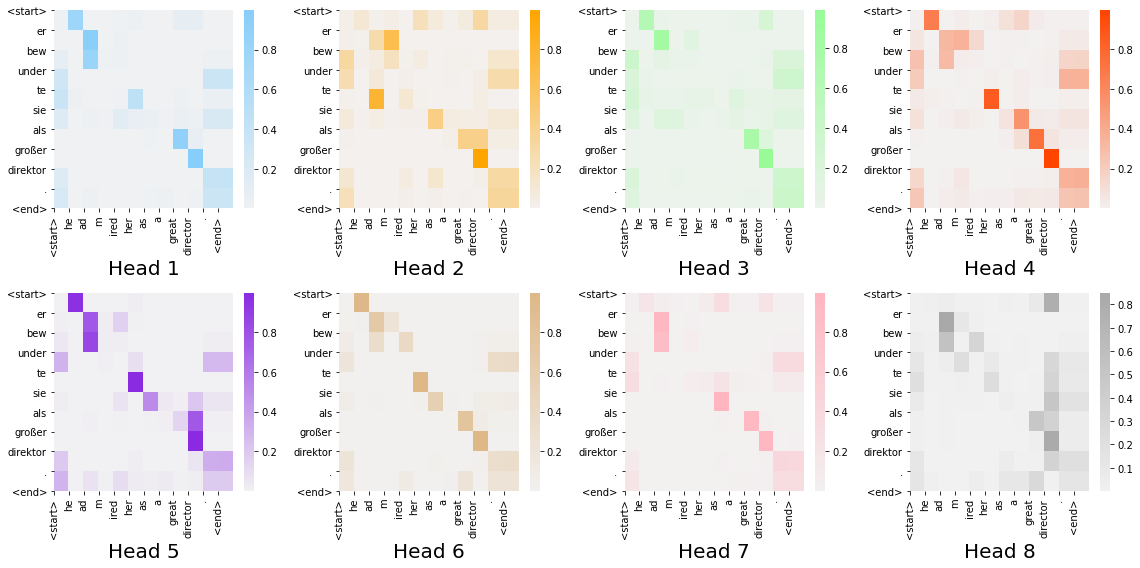

In [20]:
# The word alighments in English and German. 
translate("He admired her as a great director.", plot='decoder_layer4_block2', img_name='sample_img_3')

Input: I went to the shop to buy something to drink.
Predicted translation: ich ging in den laden, um mir etwas zu trinken zu kaufen.


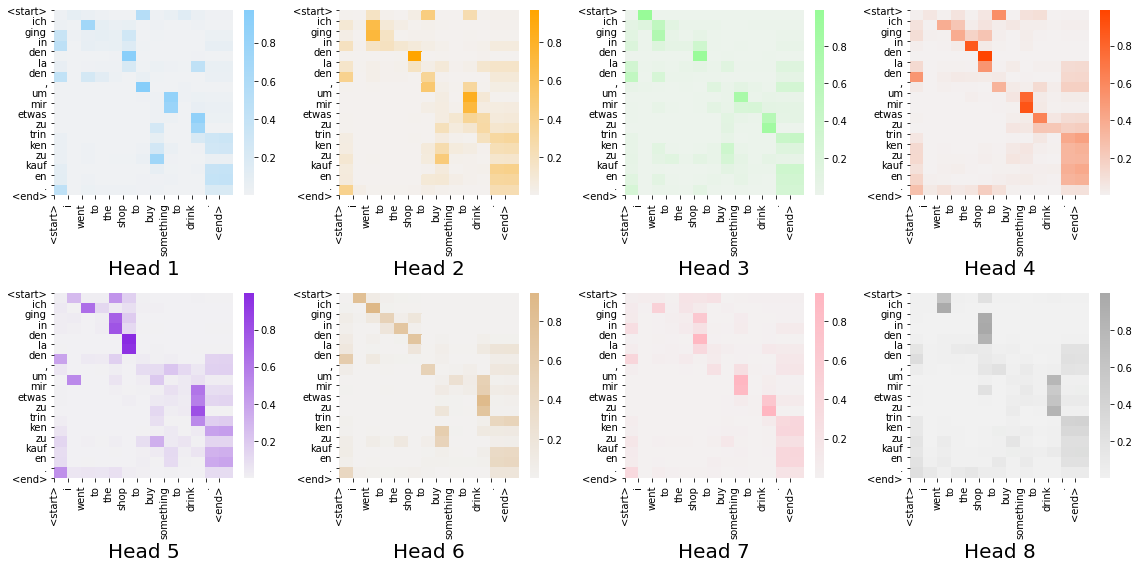

In [21]:
# With a bit more complicated input, the word alighments get more blurly. 
translate("I went to the shop to buy something to drink.", plot='decoder_layer4_block2', img_name='sample_img_3')

Input: He will have written the funniest joke in the world, and as a consequence he will die.
Predicted translation: er wird den lustigsten witz geschrieben und einen elefanten erhalten.


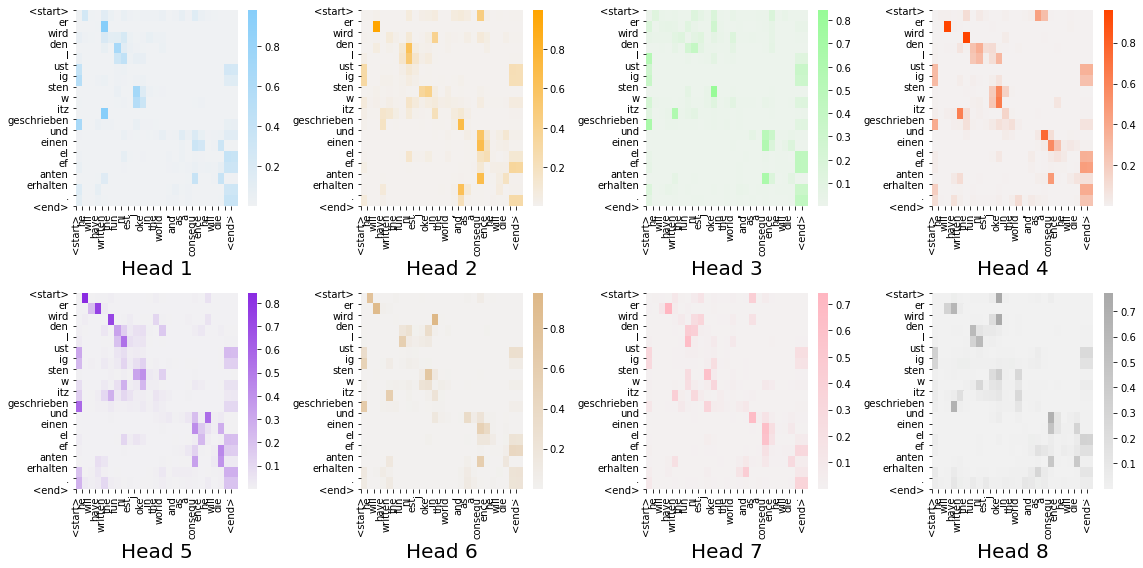

In [25]:
translate("He will have written the funniest joke in the world, and as a consequence he will die.", plot='decoder_layer4_block2', img_name='sample_img_3')